In [75]:
import os,glob
import numpy as np
import pandas as pd
import glob
import pyslha
import time
from matplotlib import pyplot as plt


delphesDir = os.path.abspath("../DelphesHSCP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

True

In [74]:
inputFile = '../test.root'
inputFile = '../Stau_0j_match/Events/run_01/stau_400_10.00ns_delphes_events.root'
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
# nevts = 3
towerParticlesR = []
towerParticlesZ = []
for ievt in range(nevts):    

    tree.GetEntry(ievt)        

    metCalo = tree.MissingETCalo.At(0)
    dmParticles = [tree.dmParticles.At(idm) for idm in range(tree.dmParticles.GetEntries())]
    dmPDGs = set([dm.PID for dm in dmParticles])

    

    for itower in range(tree.Tower.GetEntries()):
        tower = tree.Tower.At(itower)
        for ip in range(tower.Particles.GetEntries()):
            p = tower.Particles.At(ip)
            towerParticlesR.append(np.sqrt(p.X**2 + p.Y**2))    
            towerParticlesZ.append(np.sqrt(p.Z**2))
    

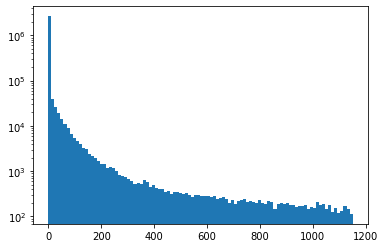

In [76]:
plt.hist(towerParticlesR,bins=100)
plt.yscale('log')
plt.show()

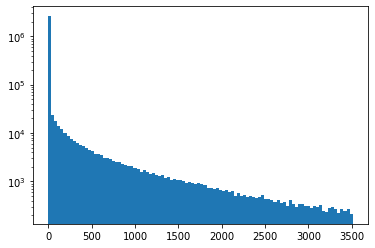

In [77]:
plt.hist(towerParticlesZ,bins=100)
plt.yscale('log')
plt.show()

In [78]:
max(towerParticlesR),max(towerParticlesZ)

(1149.998121154544, 3509.624755859375)

In [64]:
pTtot = np.array([0.,0.])
ETtot = 0.0
for itower in range(tree.Tower.GetEntries()):
    tower = tree.Tower.At(itower)
    ETtot += tower.ET
    pTtot += np.array([tower.ET*np.cos(tower.Phi),tower.ET*np.sin(tower.Phi)])
    

In [65]:
ETtot,np.sqrt(pTtot[0]**2+pTtot[1]**2),metCalo.MET

(79.0394103648141, 14.434925255335076, 14.434925079345703)

In [66]:
print(pTtot[0],pTtot[1])
print(metCalo.MET*np.cos(metCalo.Phi),metCalo.MET*np.sin(metCalo.Phi))

13.487200297756246 5.144170997868773
-13.487199540489096 -5.144172489463616


In [67]:
towerParticles = []
for itower in range(tree.Tower.GetEntries()):
    tower = tree.Tower.At(itower)
    for ip in range(tower.Particles.GetEntries()):
        p = tower.Particles.At(ip)
        towerParticles.append(p)

In [68]:
finalHSCPDaughters = []
for i in range(tree.isoHSCPs.GetEntries()):
    p = tree.isoHSCPs.At(i)
    print(p.PID)

1000015
-1000015


In [69]:
finalHSCPDaughters = []
for i in range(tree.hscpDaughters.GetEntries()):
    p = tree.hscpDaughters.At(i)
    print(p.PID)

15
1000039
-15
1000039


In [70]:
def getDaughters(p):
    if p.Status == 1:
        return []
    daughters = [tree.Particle.At(d) for d in range(p.D1,p.D2+1)]
    return daughters

stableDaughters = []
for i in range(tree.Particle.GetEntries()):
    p = tree.Particle.At(i)
    if abs(p.PID) not in [2000015,1000015]:
        continue
    if p.D1 == p.D2:
        continue
    daughters = getDaughters(p)
    unstable = []
    for d in daughters:
        if d.Status == 1:
            stableDaughters.append(d)
        else:
            unstable.append(d)
    while len(unstable) > 0:
        daughters = []
        for d in unstable:
            daughters += getDaughters(d)
        unstable = []
        for d in daughters:
            if d.Status == 1:
                stableDaughters.append(d)
            else:
                unstable.append(d)
    

In [71]:
print(len(stableDaughters))
for d in stableDaughters:
    print(d.PID,d.Status,d.PT,np.sqrt(d.X**2 + d.Y**2))

19
22 1 5.760156795986404e-09 0.0
1000039 1 186.2373504638672 3399.1295716458335
22 1 0.004081607796251774 3399.1295716458335
22 1 195.64251708984375 3399.1295716458335
-16 1 96.56175231933594 3416.2878880240173
211 1 30.261798858642578 3416.2878880240173
22 1 3.971322803408839e-05 6071.820369314743
1000039 1 329.0074768066406 6071.820369314743
16 1 22.716028213500977 6072.28070957919
-211 1 3.864588975906372 6072.28070957919
-211 1 22.522241592407227 6072.28070957919
211 1 24.54989242553711 6072.28070957919
22 1 7.769928932189941 6072.282163338579
22 1 6.703354835510254 6072.282163338579
1000039 1 186.2373504638672 3399.1295716458335
22 1 0.004081607796251774 3399.1295716458335
22 1 195.64251708984375 3399.1295716458335
-16 1 96.56175231933594 3416.2878880240173
211 1 30.261798858642578 3416.2878880240173


In [72]:
for d in towerParticles:
    if d.PID not in [22,16,-211,211,12,-11,-16,11,12,-12]:
        continue
#     if d.PT < 0.02: continue
    if np.sqrt(d.X**2 + d.Y**2) < 100.0: continue
    print(d.PID,d.PT,d.Eta,np.sqrt(d.X**2 + d.Y**2))

211 0.23201099038124084 3.234790086746216 150.4820704502029


In [73]:
for d in towerParticles:
    if d.PID not in [11,-11]: continue
    print(d.PID,d.PT,d.Eta)

-11 0.2050178498029709 2.829033136367798
11 0.133854940533638 2.846956491470337
-11 0.227779820561409 3.558393716812134
11 0.03138941526412964 3.541213274002075
